In [1]:
import numpy as np
import pandas as pd
import polarDensity_helper as pc
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent


In [2]:
global Ntheta
Ntheta = 30

file_title1 = "polar1_"
density = None
chol_bind = None
w3_bind = None
rat = None
chains_groups = None 
col = []

   
# enrich and lipids have not been implemented  

chains_groups = ["POPG", "POPE"]     
HG = ["PC","PE","SM","PS","PA","PI","P1a","P2a","P3a"]
acyl = ["n0","n9","n6","n3"]

memb="synps"
ddg=False
lipids= ["POPG", "POPE"]  
enrich=True

In [16]:
'''
memb (str) should be synps or oocyt
ddg (bool) determines if ddg analysis called
lipids (str) points to a file to check lipids
enrich (bool) tells script to check enrichment
'''

# initialization

global Ntheta
Ntheta = 30

file_title1 = "polar1_"
density = None
chol_bind = None
w3_bind = None
rat = None
chains_groups = None 
col = []
#chains_up, chains_lo = pc.prot_coord()

    
# Catches your using the right args
assert memb=="synps" or memb=="oocyt", "memb var should be synps or oocyt"

#sets up initial strings to collect data files
if memb == "synps":
    file_title1 = file_title1 + "synpR"
    #rat = pc.get_rat_val("../Data/ratio/Ratio_Synapse.csv")
    if lipids == False:    
        chains_groups = pc.Syn_ooc_comp()[1]
    else:
        chains_groups = lipids
        
if memb == "oocyt":
    file_title1 = file_title1 + "oocyR"
    #rat = pc.get_rat_val("../Data/ratio/Ratio_Oocyte.csv")
    if lipids == False:    
        chains_groups = pc.Syn_ooc_comp()[0]
    else:
        chains_groups = lipids

# get files to use
root = Path("..")
files = root.glob("*.dat*.dat")

leaflets = ['low', 'upp']

file_list = list(files)

In [17]:
densities = pd.DataFrame(index=chains_groups, columns=leaflets)
counts = pd.DataFrame(index=chains_groups, columns=leaflets)

idx = 0
for fl in file_list:
    if idx == 0:
        rad, dr, dth, theta, radius, frames = pc.Coord_Get(fl, Ntheta)

    filename = fl.name

    tmp_chain = filename.split('.')[0]
    tmp_nm = filename.split('.')[2]

    # This is a hack. The above part does not have a "flexible"
    # method to consider sim type (a, b ...)
    idx+=1
    toadd = np.loadtxt(fl, skiprows=1)
    toadd = toadd[:,3:]
    counts.at[tmp_chain,tmp_nm] = toadd
    densities.at[tmp_chain,tmp_nm] = pc._analysis_call_(fl, radius, dr, dth, frames, enrich=enrich)


In [19]:
def polar_plot(data_in, theta, radius, chains_groups):
	# plots densities
	# data_in = array/list of density data
	# theta, radius = arrays of position bins
	# chains_groups = old name, really lipids to plot

    data_in = pc.sum_reps(data_in)
    fig = plt.figure(figsize=(10,10))
    gs1=gridspec.GridSpec(len(chains_groups),2,wspace=.15, hspace=0.15)
    max_norm = 0.003#
    plt.rcParams.update({'font.size': 10})
    norm1 = pc.MidpointNormalize(midpoint=max_norm/2,vmin=0,vmax=max_norm)
    norm1 = pc.MidpointNormalize(midpoint=1,vmin=0,vmax=2)
    cmap = plt.cm.RdBu_r#PuOr
    cmap.set_bad(color='black')
    grid = 0
    #chains_up, chains_lo = prot_coord()
    sub = ["g",'m','grey','green','cyan']

    for cg in chains_groups:
        for leaf in data_in.columns:
            ax = plt.subplot(gs1[grid],projection="polar")
            toplot = data_in.at[cg,leaf]
            s = ax.pcolormesh(theta, radius, toplot,cmap=cmap,norm=norm1,zorder=0)

            ax.set_xticklabels([])
            ax.set_yticklabels([])
            grid = grid + 1
            
            #for i,pro in enumerate(chains_lo[:5]):
            #    ax.scatter(np.deg2rad(pro[1::2]),pro[::2],edgecolor=sub[i],facecolors=sub[i],linewidth=1,zorder=2, s=np.shape(data_in)[0]*10)


    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.21, .89, 0.5, 0.008])
    fig.colorbar(s, cax=cbar_ax,ticks=[0,0.5,1,1.5,2],orientation="horizontal")

    plt.tight_layout()
    plt.show()

In [20]:
A

array([[  7.85398163,   7.85398163,   7.85398163,   7.85398163,
          7.85398163,   7.85398163,   7.85398163,   7.85398163,
          7.85398163,   7.85398163,   7.85398163,   7.85398163,
          7.85398163,   7.85398163,   7.85398163,   7.85398163,
          7.85398163,   7.85398163,   7.85398163,   7.85398163,
          7.85398163,   7.85398163,   7.85398163,   7.85398163,
          7.85398163,   7.85398163,   7.85398163,   7.85398163,
          7.85398163,   7.85398163,   7.85398163],
       [ 13.08996939,  13.08996939,  13.08996939,  13.08996939,
         13.08996939,  13.08996939,  13.08996939,  13.08996939,
         13.08996939,  13.08996939,  13.08996939,  13.08996939,
         13.08996939,  13.08996939,  13.08996939,  13.08996939,
         13.08996939,  13.08996939,  13.08996939,  13.08996939,
         13.08996939,  13.08996939,  13.08996939,  13.08996939,
         13.08996939,  13.08996939,  13.08996939,  13.08996939,
         13.08996939,  13.08996939,  13.08996939],
  

/var/folders/6r/xh2vl9x55r14p75b9l5217hw0000gn/T/ipykernel_68755/4194697052.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


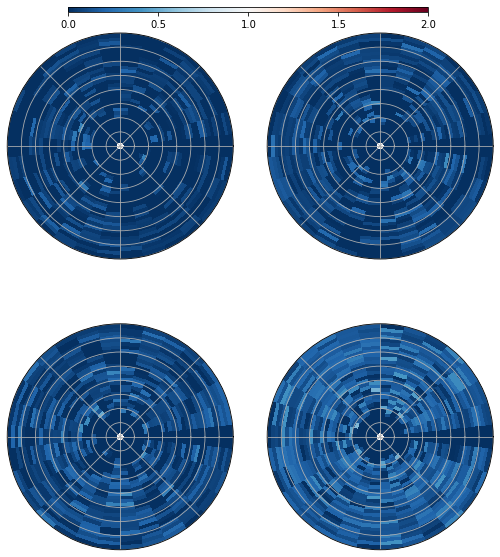

In [21]:
A = radius*dr*dth
densities = counts
for lip in lipids:
    for leaf in leaflets:
        densities.at[lip, leaf] = counts.at[lip, leaf]/A
polar_plot(densities, theta, radius, chains_groups)